> Это пример решения задачи с использованием Keras. Вы можете использовать этот кернер для дальнейших исследований и экспериментов.
# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть Xception и дообучить под нашу задачу. 
По ходу решения мы будем давать вам рекомендации, которые помогут улучшить качество модели. 


Удачи и Поехали!

In [1]:
!nvidia-smi

Tue Oct  6 20:06:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB6

from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import keras

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['test.zip', 'train.csv', 'train.zip', 'sample-submission.csv']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


In [3]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

**Работаем с Tensorflow v2**

In [4]:
!pip freeze > requirements.txt

# Основные настройки

In [5]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%
    
CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [6]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [7]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [9]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [10]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


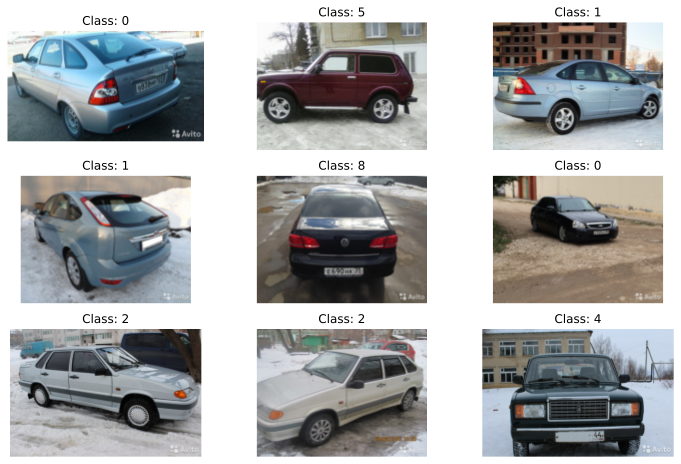

In [11]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

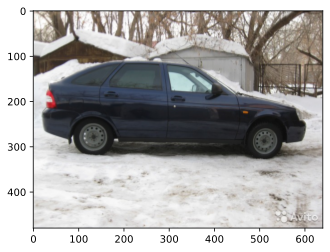

(640, 480)

In [12]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [13]:
# Вы помните, что аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.
# Чтобы лучше понять работу параметров, попробуйте их изменить. К какому результату это приведет?
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

### Генерация данных

In [14]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Пример картинок из train_generator


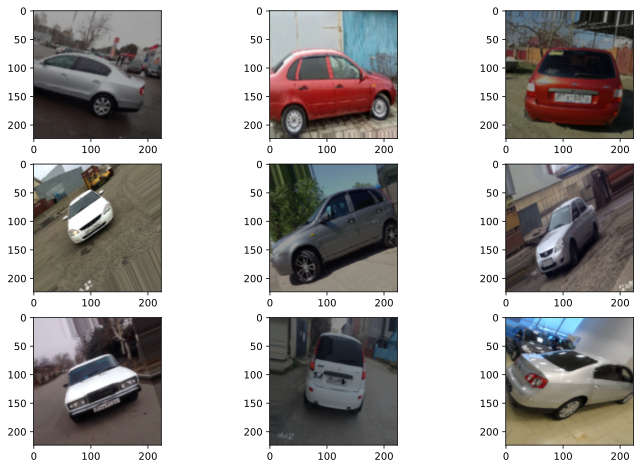

In [15]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Функция для отрисовки графиков обучения

In [16]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

# Построение модели

### Загружаем предобученную сеть ResNet50V2:

In [17]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [18]:
#base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

In [19]:
#base_model = tf.keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [20]:
#base_model.summary()
# Рекомендация: Попробуйте и другие архитектуры сетей

In [21]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

In [22]:
# # Устанавливаем новую "голову" (head)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.25)(x)
# # and a logistic layer -- let's say we have 10 classes
# predictions = Dense(CLASS_NUM, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [23]:
# # # Устанавливаем новую "голову" (head)

# import keras
# model=keras.models.Sequential()
# model.add(base_model)
# #model.add(keras.layers.GlobalAveragePooling2D(),)
# #model.add(L.Dense(512,activation='relu'))
# #model.add(L.BatchNormalization())
# #predictions = model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

# # точно так же, как в оригинальной модели, сначала делаем глобальный пулинг
# new_output = keras.layers.GlobalAveragePooling2D()(model.output)
# # софтмакс для новых классов
# predictions = keras.layers.Dense(CLASS_NUM, activation='softmax')(new_output)

# # this is the model we will train
# #model = Model(inputs=base_model.input, outputs=predictions)
# model = keras.engine.training.Model(model.inputs, predictions)
# model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [24]:
# import keras
# model=M.Sequential()
# model.add(base_model)
# model.add(keras.layers.GlobalAveragePooling2D(),)
# #model.add(L.Dense(512,activation='relu'))
# #model.add(L.BatchNormalization())
# model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [25]:
# model=keras.models.Sequential()
# model.add(base_model)
# model.add(keras.layers.GlobalAveragePooling2D(),)
# #model.add(keras.layers.Dense(512,activation='relu'))
# #model.add(keras.layers.BatchNormalization())
# predictions = model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

# #predictions = Dense(CLASS_NUM, activation='softmax')(x)

# # # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [27]:
model.summary()
# Рекомендация: Попробуйте добавить Batch Normalization

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [28]:
len(model.layers)

136

In [29]:
len(model.trainable_variables)

4

In [30]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efbf0480a50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efc0e20e050> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efbf0ca3490> False
<tensorflow.python.keras.layers.core.Activation object at 0x7efbf00bf890> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efbf0c9fe50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efb739dbb50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7efb739e3b10> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7efb73970a90> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efbf0c9f350> False
<tensorflow.python.keras.layers.core.Activation object at 0x7efb739a78d0> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7efb739391d0> False
<tensorflow.pyt

### Fit
* LR=0.001
* base_model.trainable = False

In [31]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [32]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [33]:
scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 3ms/step - loss: 2.4089 - accuracy: 0.0938
Accuracy: 9.38%


In [34]:
# Обучаем
# history = model.fit_generator(
#         train_generator,
#         steps_per_epoch = train_generator.samples//train_generator.batch_size,
#         validation_data = test_generator, 
#         validation_steps = test_generator.samples//test_generator.batch_size,
#         epochs = 10,
#         callbacks = callbacks_list
# )


history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)


Epoch 1/5
414/414 [==============================] - ETA: 0s - loss: 1.8149 - accuracy: 0.3450
Epoch 00001: saving model to best_model.hdf5
414/414 [==============================] - 271s 654ms/step - loss: 1.8149 - accuracy: 0.3450 - val_loss: 1.6197 - val_accuracy: 0.4208
Epoch 2/5
414/414 [==============================] - ETA: 0s - loss: 1.5375 - accuracy: 0.4510
Epoch 00002: saving model to best_model.hdf5
414/414 [==============================] - 264s 637ms/step - loss: 1.5375 - accuracy: 0.4510 - val_loss: 1.4658 - val_accuracy: 0.4766
Epoch 3/5
414/414 [==============================] - ETA: 0s - loss: 1.4329 - accuracy: 0.4825
Epoch 00003: saving model to best_model.hdf5
414/414 [==============================] - 272s 656ms/step - loss: 1.4329 - accuracy: 0.4825 - val_loss: 1.3587 - val_accuracy: 0.5243
Epoch 4/5
414/414 [==============================] - ETA: 0s - loss: 1.3623 - accuracy: 0.5150
Epoch 00004: saving model to best_model.hdf5
414/414 [==========================

In [35]:
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

In [36]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 40s 549ms/step - loss: 1.3033 - accuracy: 0.5311
Accuracy: 53.11%


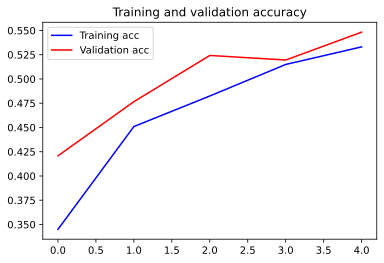

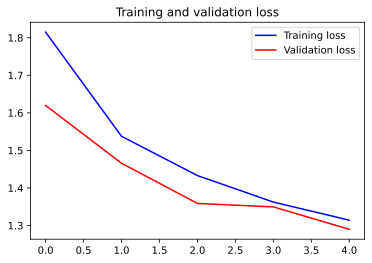

In [37]:
plot_history(history)

### Step 2
* half trainable layers
* LR=0.0001

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [39]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [40]:
len(base_model.trainable_variables)

79

In [41]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efbf0480a50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efc0e20e050> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efbf0ca3490> False
<tensorflow.python.keras.layers.core.Activation object at 0x7efbf00bf890> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efbf0c9fe50> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efb739dbb50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7efb739e3b10> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7efb73970a90> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efbf0c9f350> False
<tensorflow.python.keras.layers.core.Activation object at 0x7efb739a78d0> False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7efb739391d0> False
<tensorflow.pyt

In [42]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [43]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [44]:
scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 3ms/step - loss: 1.2483 - accuracy: 0.5312
Accuracy: 53.12%


In [45]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

Epoch 1/10
413/413 [==============================] - ETA: 0s - loss: 0.7916 - accuracy: 0.7135
Epoch 00001: saving model to best_model.hdf5
413/413 [==============================] - 281s 681ms/step - loss: 0.7916 - accuracy: 0.7135 - val_loss: 0.4708 - val_accuracy: 0.8277
Epoch 2/10
413/413 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8572
Epoch 00002: saving model to best_model.hdf5
413/413 [==============================] - 280s 678ms/step - loss: 0.3954 - accuracy: 0.8572 - val_loss: 0.3590 - val_accuracy: 0.8672
Epoch 3/10
413/413 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.8981
Epoch 00003: saving model to best_model.hdf5
413/413 [==============================] - 279s 675ms/step - loss: 0.2809 - accuracy: 0.8981 - val_loss: 0.3107 - val_accuracy: 0.8937
Epoch 4/10
413/413 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9160
Epoch 00004: saving model to best_model.hdf5
413/413 [======================

In [46]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [47]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 39s 531ms/step - loss: 0.2657 - accuracy: 0.9150
Accuracy: 91.50%


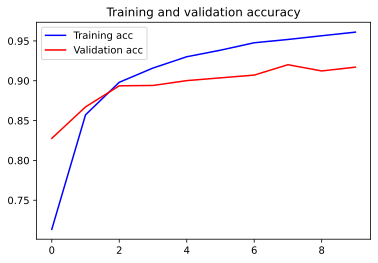

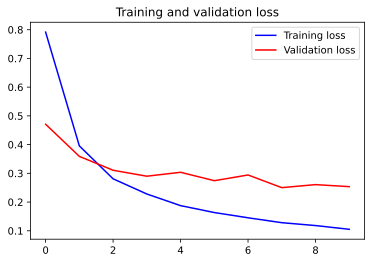

In [48]:
plot_history(history)

### Step 3
* LR=0.00001
* all trainable layers

In [49]:
base_model.trainable = True

In [50]:
# base_model.trainable = True

# # Fine-tune from this layer onwards
# fine_tune_at = 50

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

# len(base_model.trainable_variables)

In [51]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [52]:
scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 2ms/step - loss: 0.2259 - accuracy: 0.9062
Accuracy: 90.62%


In [53]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

Epoch 1/10
413/413 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9563
Epoch 00001: saving model to best_model.hdf5
413/413 [==============================] - 321s 778ms/step - loss: 0.1187 - accuracy: 0.9563 - val_loss: 0.2462 - val_accuracy: 0.9223
Epoch 2/10
413/413 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9662
Epoch 00002: saving model to best_model.hdf5
413/413 [==============================] - 321s 778ms/step - loss: 0.0943 - accuracy: 0.9662 - val_loss: 0.2291 - val_accuracy: 0.9258
Epoch 3/10
413/413 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9722
Epoch 00003: saving model to best_model.hdf5
413/413 [==============================] - 321s 778ms/step - loss: 0.0777 - accuracy: 0.9722 - val_loss: 0.2539 - val_accuracy: 0.9193
Epoch 4/10
413/413 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9727
Epoch 00004: saving model to best_model.hdf5
413/413 [======================

In [54]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [55]:
scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 2ms/step - loss: 0.2663 - accuracy: 0.9062
Accuracy: 90.62%


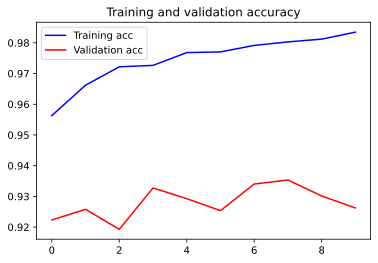

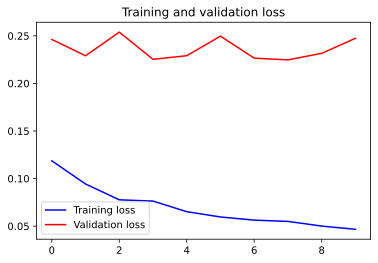

In [56]:
plot_history(history)

### Step 4

* LR = 0.00001
* degrese batchsize
* degrese augumentation
* increase image size: IMG_SIZE = 320

In [67]:
EPOCHS               = 10
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5
IMG_SIZE             = 320
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [69]:
# train_datagen = ImageDataGenerator(rescale=1. / 255, 
#                                     rotation_range = 60,
#                                     #shear_range=0.2,
#                                     zoom_range=[0.75,1.25],
#                                     #brightness_range=[0.5, 1.5],
#                                     #width_shift_range=0.1,
#                                     #height_shift_range=0.1,
#                                     horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1. / 255)

In [76]:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 20,
    #shear_range=0.2,
    zoom_range=[0.75,1.25],
    #brightness_range=[0.5, 1.5],
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)


In [74]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [77]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [78]:
base_model.trainable = True
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [79]:
scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 5ms/step - loss: 0.1515 - accuracy: 0.9375
Accuracy: 93.75%


In [80]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 15,
        callbacks = callbacks_list
)

Epoch 1/15
413/413 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9811
Epoch 00001: saving model to best_model.hdf5
413/413 [==============================] - 552s 1s/step - loss: 0.0521 - accuracy: 0.9811 - val_loss: 0.1317 - val_accuracy: 0.9592
Epoch 2/15
413/413 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9846
Epoch 00002: saving model to best_model.hdf5
413/413 [==============================] - 548s 1s/step - loss: 0.0415 - accuracy: 0.9846 - val_loss: 0.1418 - val_accuracy: 0.9527
Epoch 3/15
413/413 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9876
Epoch 00003: saving model to best_model.hdf5
413/413 [==============================] - 550s 1s/step - loss: 0.0349 - accuracy: 0.9876 - val_loss: 0.1464 - val_accuracy: 0.9553
Epoch 4/15
413/413 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9905
Epoch 00004: saving model to best_model.hdf5
413/413 [==============================]

In [81]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [82]:
scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9688
Accuracy: 96.88%


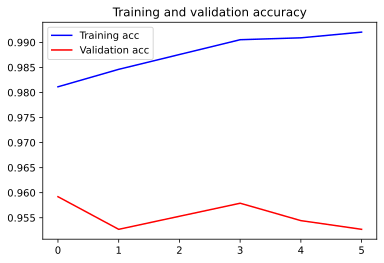

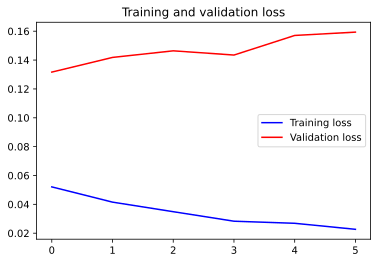

In [83]:
plot_history(history)

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
# checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
# earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# callbacks_list = [checkpoint, earlystop]

# # checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
# # callbacks_list = [checkpoint]

# # Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/
# # Рекомендация 2. Используйте разные техники управления Learning Rate
# # https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
# # http://teleported.in/posts/cyclic-learning-rate/ (eng)

Обучаем:

In [ ]:
# history = model.fit_generator(
#         train_generator,
#         steps_per_epoch = len(train_generator),
#         validation_data = test_generator, 
#         validation_steps = len(test_generator),
#         epochs = EPOCHS,
#         callbacks = callbacks_list
# )

# # Рекомендация: попробуйте применить transfer learning с fine-tuning

In [ ]:
# # сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
# model.save('../working/model_last.hdf5')
# model.load_weights('best_model.hdf5')

In [ ]:
# scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

В Итоге точность нашей модели составила 93%. 
Учитывая что классов 10 - это Очень хороший результат!     
Посмотрим графики обучения:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Предсказание на тестовых данных

In [84]:
test_sub_generator.samples

6675

In [85]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

209/209 [==============================] - 56s 268ms/step


In [86]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [87]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


In [88]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

## Интересно, к какому классу модель отнесет вот эти автомобили?

# Что можно сделать, чтобы улучшить результат:

* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!